# Import and Cleaning

In [1]:
# adding path to import custom functions
import sys
sys.path.append("/home/artur/code/masters-project/main_project/notebooks/model_creation/models")

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime

from functions import remove_high_corr, scale_variables, best_params_grid, calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label, get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from ISLP.bart import BART

import session_info 

In [4]:
data = pd.read_csv("../../data/fda_approved/fda_padel_pre_processed_descriptors_no_inputation.csv")
data.head()

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,6.560927,6.732051,1.683013,6.732051,0.000000,6.732051e+00,9.0,0.0,-0.646,12.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,7.503203,8.696802,1.739360,7.228927,4.642168,2.586760e+00,18.0,2.0,-0.728,16.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,8.447475,8.696802,1.739360,9.541980,4.642168,4.899812e+00,18.0,2.0,-1.606,16.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,7.002720,6.871320,1.717830,4.621320,0.000000,2.310660e+00,10.0,1.0,0.106,10.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,7.801394,6.732051,1.683013,4.976068,2.244017,8.881784e-16,9.0,0.0,-0.786,12.0


In [5]:
Y = data["oral"]
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: oral, dtype: float64

In [6]:
X = data.iloc[:, 14:]
X.head()

,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,nB,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,-0.4695,0.220430,11.1997,8.393965,0.0,0.0,9.0,4.0,5.0,0.0,...,6.560927,6.732051,1.683013,6.732051,0.000000,6.732051e+00,9.0,0.0,-0.646,12.0
1,-1.0852,1.177659,15.4305,9.557965,0.0,0.0,10.0,5.0,5.0,0.0,...,7.503203,8.696802,1.739360,7.228927,4.642168,2.586760e+00,18.0,2.0,-0.728,16.0
2,-1.0880,1.183744,12.5072,8.231172,0.0,0.0,9.0,5.0,4.0,0.0,...,8.447475,8.696802,1.739360,9.541980,4.642168,4.899812e+00,18.0,2.0,-1.606,16.0
3,-0.2157,0.046526,22.3381,12.187551,0.0,0.0,11.0,4.0,7.0,0.0,...,7.002720,6.871320,1.717830,4.621320,0.000000,2.310660e+00,10.0,1.0,0.106,10.0
4,-0.5895,0.347510,11.3934,11.222758,0.0,0.0,10.0,4.0,6.0,0.0,...,7.801394,6.732051,1.683013,4.976068,2.244017,8.881784e-16,9.0,0.0,-0.786,12.0


In [7]:
# separate train an test datasets

np.random.seed(750059)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Constant Variables

In [8]:
DESCRIPTOR_TYPE = "padel_no_inputation"

# Scaling datsets

The datasets are being scaled to be used, when necessary, scaled

In [9]:
# TRAIN

x_train_scaled = scale_variables(x_train)

# adding constant
x_train_scaled = sm.add_constant(x_train_scaled)

x_train_scaled.head()

,const,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,1.0,-0.795767,0.070400,0.383925,0.367736,-0.413303,-0.478037,0.441438,0.282922,0.549551,...,-0.559442,0.270138,0.014771,-0.029428,0.363229,-0.144048,-0.054639,0.040813,0.642002,0.184241
1,1.0,0.891981,-0.234984,-1.006690,-0.478179,1.239590,1.061196,-0.493158,-0.133746,-0.774925,...,0.715452,-0.137578,0.067753,0.473407,-0.841376,1.180473,-0.225522,-0.123600,-0.312795,-0.116973
2,1.0,0.121050,-0.274724,-0.856331,-0.905746,0.037486,0.081684,-0.940139,-0.883750,-0.922089,...,0.418761,-0.888607,-0.214956,-0.505946,-0.575686,-0.301634,-0.358399,-0.863454,-0.524582,-0.870007
3,1.0,0.876318,-0.238791,0.634921,1.035941,1.239590,1.201126,0.807150,1.032926,0.549551,...,0.351014,0.990667,-0.193961,0.635744,0.403889,-0.193531,0.443901,0.698461,1.498970,0.816789
4,1.0,1.629929,0.085415,-0.897213,-1.649783,-1.314881,-1.317619,-1.590293,-1.550419,-1.510745,...,3.399208,-1.611363,-3.971652,-0.619581,-0.835474,-1.124167,-0.412241,-1.438897,-0.411676,-1.592920


In [10]:
# TEST

x_test_scaled = scale_variables(x_test)

# adding constant
x_test_scaled = sm.add_constant(x_test_scaled)

x_test_scaled.head()

,const,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,1.0,0.614036,-0.263678,-0.778835,-0.894890,-0.380504,-0.458144,-0.792770,-1.094056,-0.475380,...,-1.046877,-1.117703,-1.003800,-1.231958,-0.811002,-0.773239,-0.445656,-1.099489,-0.154760,-1.146016
1,1.0,0.344185,-0.278075,-0.602394,-1.339201,-1.351302,-1.346818,-1.239614,-1.462976,-0.960525,...,-0.150349,-1.528425,-3.445271,-0.842355,-0.576701,-0.769716,-0.482398,-1.365667,-1.711787,-1.471107
2,1.0,-0.220189,-0.192969,1.076198,0.438685,-0.542303,-0.606256,0.413709,0.934999,-0.071093,...,0.755348,0.884992,-0.163100,2.289729,2.472764,0.854537,0.343428,0.497580,-0.862467,0.772023
3,1.0,-0.898544,0.115626,0.871281,0.248744,-1.351302,-1.346818,0.413709,0.012701,0.737482,...,-0.920795,-0.054111,-0.772613,-0.560869,0.471520,-1.179262,-0.092935,-0.478406,-0.040683,-0.300778
4,1.0,0.713909,-0.249313,-0.801084,-0.487992,0.590295,0.430530,-0.614032,-0.540678,-0.637095,...,0.146982,-0.491116,0.928156,-0.888757,-1.219081,-0.088819,-0.363095,-0.345317,0.655581,-0.495833


# Logistic Regression

## Model Constant Variables

In [11]:
model_name_title = "Logistic Regression"
model_name_path = "logistic_regression"

## Cross Validation

Here, I will use the best_params_grid function, which looks for the best hyperparameters, using CV. There are no hyperparameters in Logistic Regression, so this function will only perform CV.

In [12]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {}
    }
}

In [13]:
gs_result_lr, gs_result_lr_full = best_params_grid(x_train, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 10:59


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Finished Grid Search for Logistic Regression: 10:59
Tempo de execução:  0.1 minutos


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
gs_result_lr

,model,best_score,best_params
0,Logistic Regression,0.596802,{}


## Fitting Model to Train Dataset

To fit the model, I will use the Logit function, from the statsmodel library, because it gives more information about feature importance.

In [15]:
# adjusting y_train index and type

y_train.index = range(0, x_train_scaled.shape[0])

In [16]:
# calculatin model
log_reg = sm.Logit(y_train, x_train_scaled).fit(method='bfgs')
log_reg_results = log_reg.summary()

/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1360: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.328825
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Get Training Error and AUC

In [17]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model=log_reg, 
    x=x_train_scaled,
    y_true=y_train,
    transform_prob_into_label=True
)

Training Misclassification Rate: 0.1463
Training AUC: 0.8370


## Make Predictions

In [18]:
# the log_reg algorithm predicts as probabilities
y_predict_lr_prob = log_reg.predict(x_test_scaled)

In [19]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

make_label_v = np.vectorize(make_label)
y_predict_labels_lr = make_label_v(y_predict_lr_prob)

## Test Error

In [20]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_labels_lr,
)

Misclassification rate: 0.3729


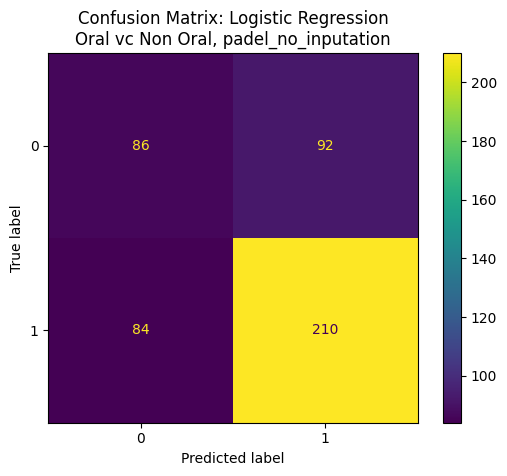

In [21]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

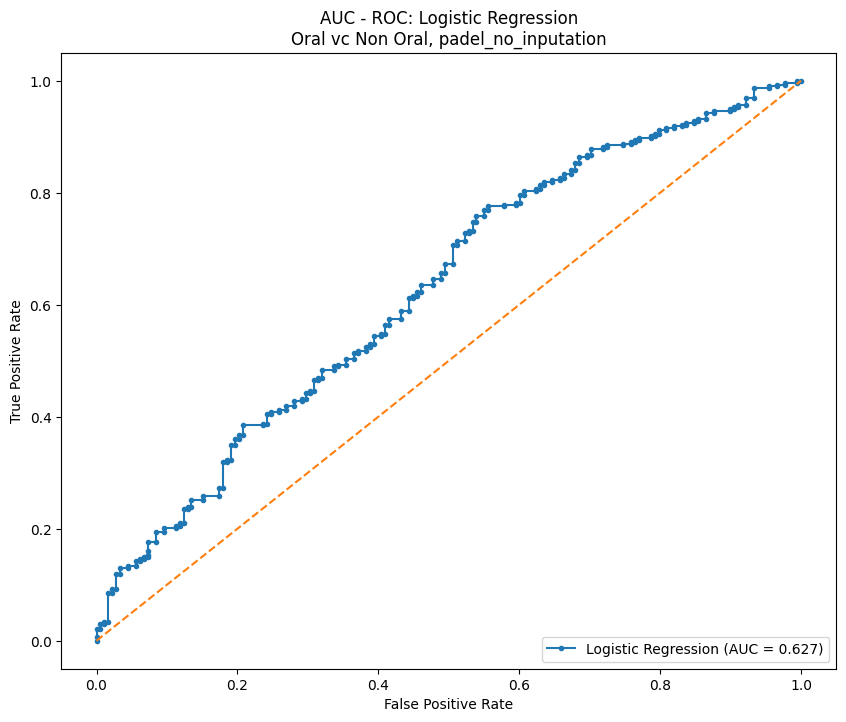

In [22]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_lr_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

In [23]:
# converting results summary to pandas dataframe
results_log_reg_html = log_reg_results.tables[1].as_html()
results_log_reg_df = pd.read_html(results_log_reg_html, header=0, index_col=0)[0]
print(results_log_reg_df.shape)
results_log_reg_df.head()

(1220, 6)


,coef,std err,z,P>|z|,[0.025,0.975]
const,1.0418,NaN,NaN,NaN,NaN,NaN
ALogP,0.4202,NaN,NaN,NaN,NaN,NaN
ALogp2,0.2608,NaN,NaN,NaN,NaN,NaN
AMR,0.2732,NaN,NaN,NaN,NaN,NaN
apol,0.0804,NaN,NaN,NaN,NaN,NaN


In [24]:
important_features_lr = results_log_reg_df[results_log_reg_df["P>|z|"] < 0.05]
print(important_features_lr.shape)
important_features_lr

(0, 6)


,coef,std err,z,P>|z|,[0.025,0.975]


## Saving Results

In [25]:
# creating dataset to store final results from each model
final_results = pd.DataFrame(
    columns=[
        "model_name", 
        "cv_test_auc", 
        "training_mis_rate", 
        "test_mis_rate", 
        "training_auc",
        "test_auc"
    ]
)

In [26]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_lr["best_score"][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.596802,0.14629,0.372881,0.836953,0.626844


In [27]:
important_features_lr.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# TREES

# Decision Tree

## Model Constant Variables

In [28]:
model_name_title = "Decision Tree"
model_name_path = "decision_tree"

## Hyperparameter Fine Tuning

In [29]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [1, 5, 10, 20, 50, 100, 150],
            'ccp_alpha': [0, 0.0001, 0.001, 0.1, 0.5, 1]
        }
    }
}

In [30]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Decision Tree: 10:59


Finished Grid Search for Decision Tree: 11:53
Tempo de execução:  53.8 minutos


In [31]:
gs_result_dt

,model,best_score,best_params
0,Decision Tree,0.632305,"{'ccp_alpha': 0.0001, 'criterion': 'gini', 'ma..."


## Fitting Tree

In [32]:
decision_tree_params = gs_result_dt.iloc[0,2]
decision_tree_params

{'ccp_alpha': 0.0001, 'criterion': 'gini', 'max_depth': 5}

In [33]:
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train, y_train)

## Get Training Error and AUC

In [34]:
mis_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.2700
Training AUC: 0.6511


## Make Predictions

In [35]:
y_predict_dt_label = decision_tree.predict(x_test)
y_predict_dt_prob = decision_tree.predict_proba(x_test)[:, 1]

## Test Error

In [36]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_dt_label,
)

Misclassification rate: 0.3517


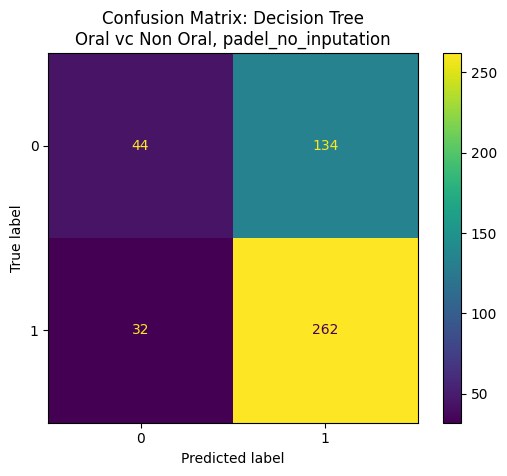

In [37]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

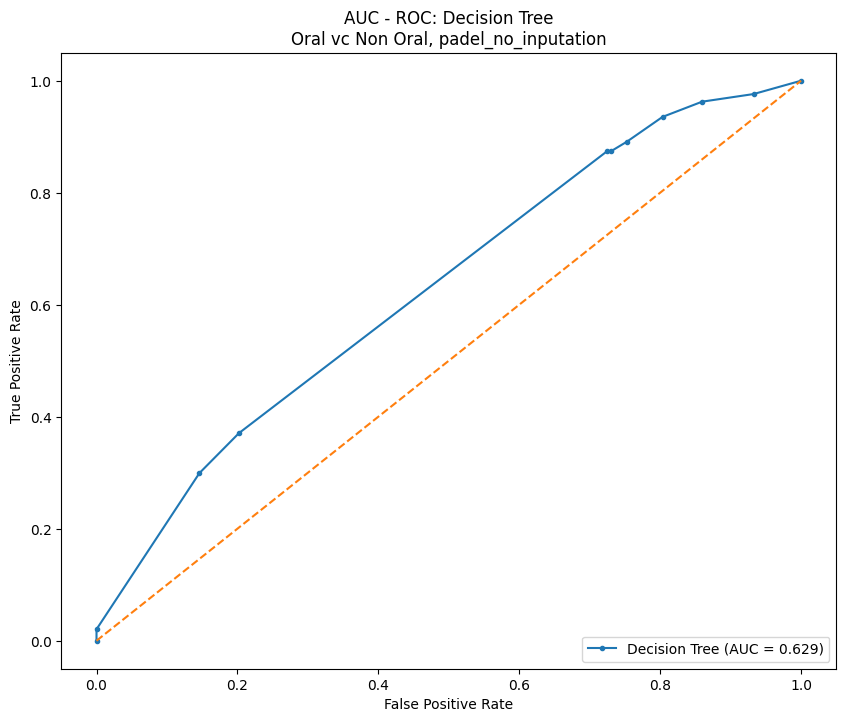

In [38]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Visualizing the Tree

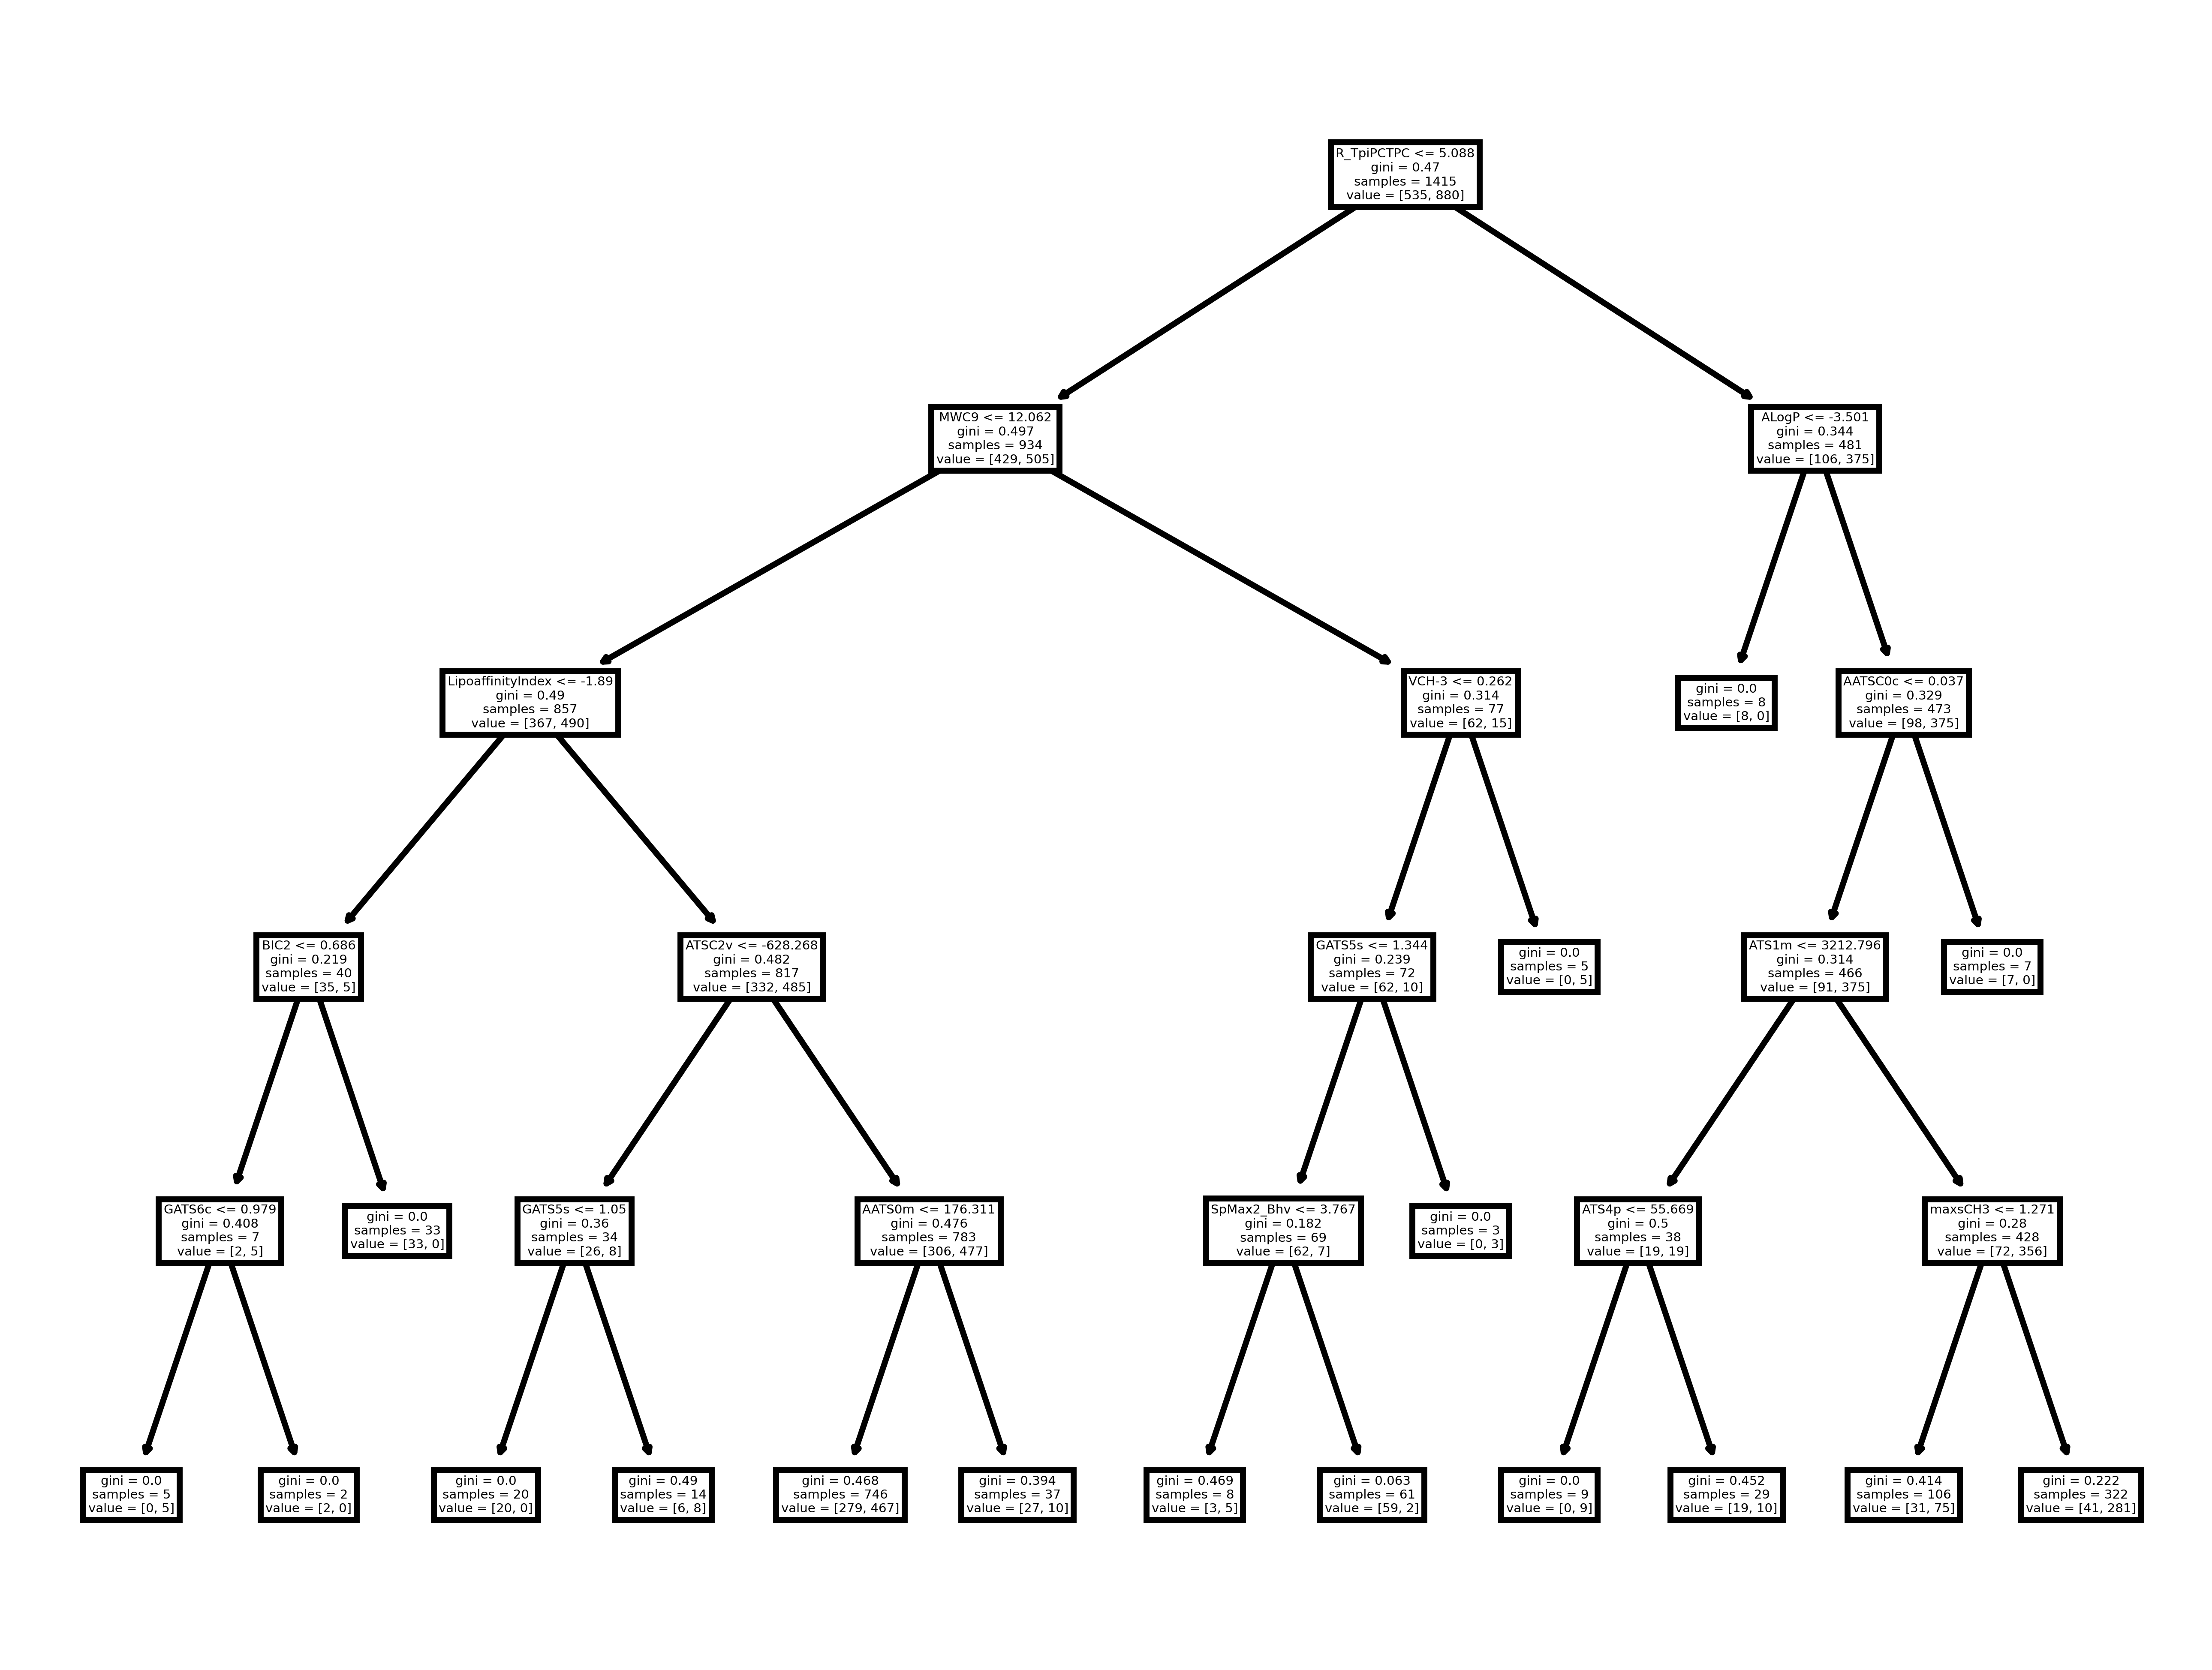

In [39]:
fig, ax = plt.subplots()
fig.dpi = 1000

tree.plot_tree(decision_tree, ax=ax, feature_names=list(x_train.columns))
plt.show()

fig.savefig(f"imgs/decision_tree_{DESCRIPTOR_TYPE}", dpi=1000)

## Feature Importance

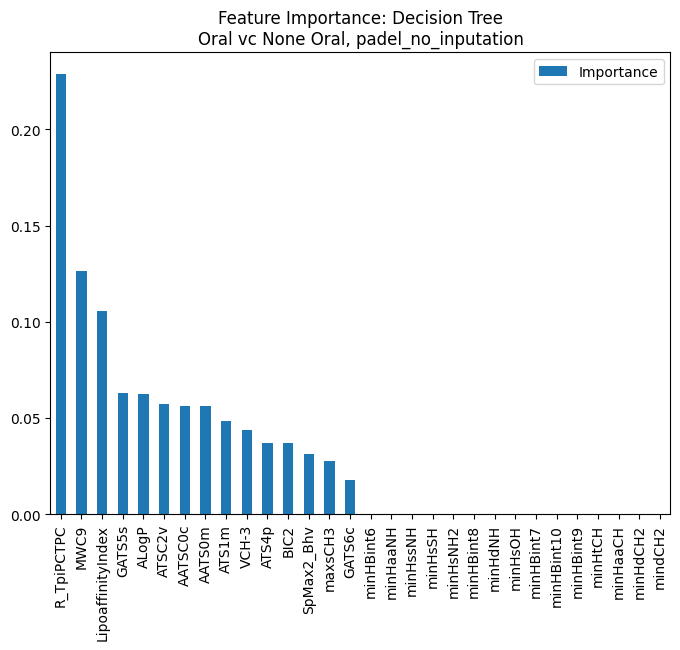

In [40]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(decision_tree.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [41]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_dt

,Importance
GATS6c,0.018023
maxsCH3,0.027432
SpMax2_Bhv,0.031293
BIC2,0.037172
ATS4p,0.037195
VCH-3,0.043737
ATS1m,0.048467
AATS0m,0.056280
AATSC0c,0.056342
ATSC2v,0.057471


## Saving Results

In [42]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_dt["best_score"][0],
    mis_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.596802,0.146290,0.372881,0.836953,0.626844
1,Decision Tree,0.632305,0.269965,0.351695,0.651051,0.629032


In [43]:
important_features_dt.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Random Forest and Bagging

Bagging is just Random Forest, in which max_features is equal to the total number of features. Therefore, bagging will be done in the RF algorithm, and compared to RF.

## Model Constant Variables

In [44]:
model_name_title = "Random Forest"
model_name_path = "random_forest"

## Hyperparameter Fine Tuning

In [58]:
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 500, 1000], # number of trees
            'max_depth': [10, 50, 100],
            'max_features': ["sqrt", "log2"], # m, number of features considered in split. When it is equal to all predictor of dataset, it is bagging
            'ccp_alpha': [0, 0.1, 0.5]
        }
    }
}

In [59]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Random Forest: 17:16


Finished Grid Search for Random Forest: 19:55
Tempo de execução:  158.7 minutos


In [60]:
gs_result_rf

,model,best_score,best_params
0,Random Forest,0.700517,"{'ccp_alpha': 0, 'max_depth': 100, 'max_featur..."


## Fitting Model

In [61]:
random_forest_params = gs_result_rf.iloc[0,2]
random_forest_params

{'ccp_alpha': 0,
 'max_depth': 100,
 'max_features': 'log2',
 'n_estimators': 1000}

In [62]:
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train, y_train)

## Get Training Error and AUC

In [63]:
mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=random_forest, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0028
Training AUC: 0.9963


## Make Predictions

In [64]:
y_predict_rf_label = random_forest.predict(x_test)
y_predict_rf_prob = random_forest.predict_proba(x_test)[:, 1]

## Test Error

In [65]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_rf_label,
)

Misclassification rate: 0.2945


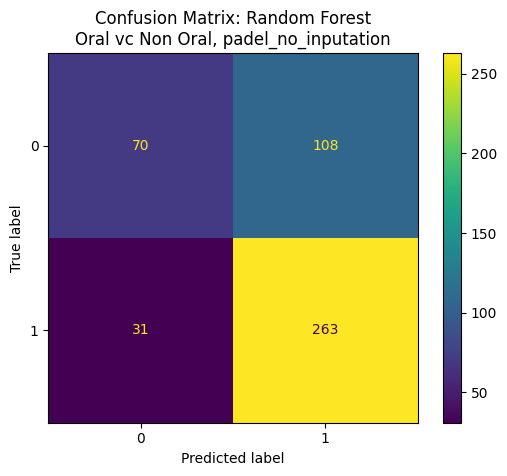

In [66]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

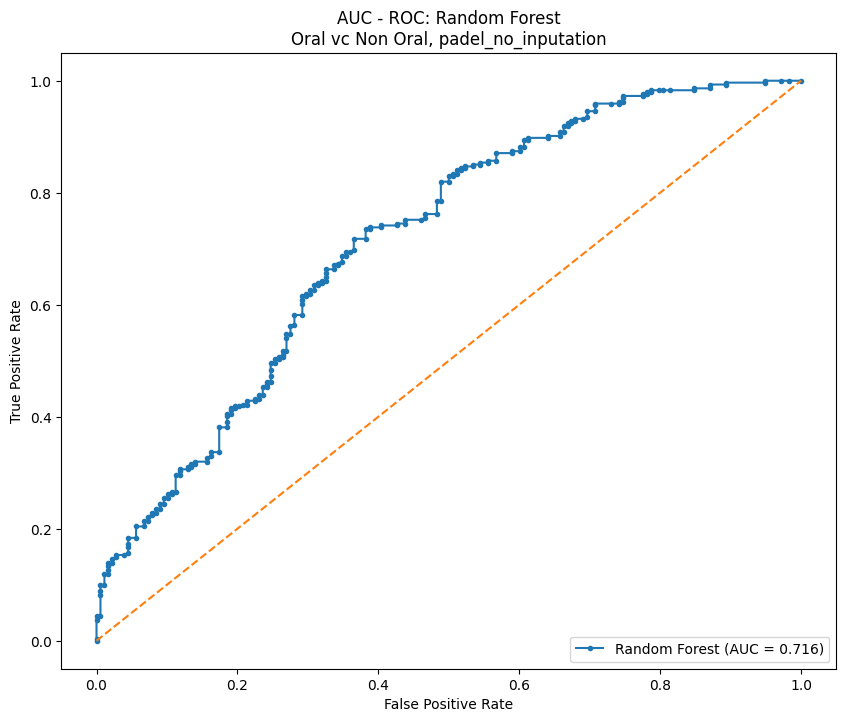

In [67]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

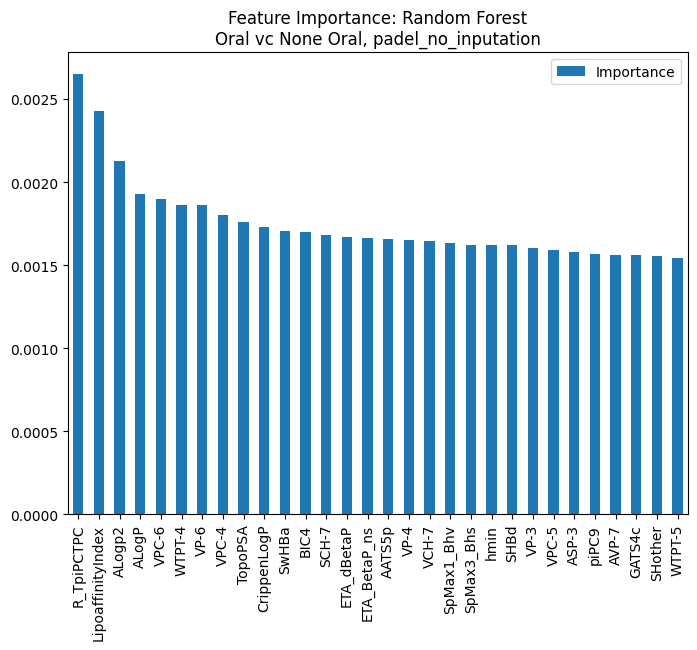

In [68]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(random_forest.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [69]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_rf

,Importance
nsI,0.000002
n9HeteroRing,0.000003
minsI,0.000003
nHsSH,0.000005
SHsSH,0.000005
...,...
VPC-6,0.001901
ALogP,0.001930
ALogp2,0.002128
LipoaffinityIndex,0.002429


## Saving Results

In [70]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_rf["best_score"][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.596802,0.146290,0.372881,0.836953,0.626844
1,Decision Tree,0.632305,0.269965,0.351695,0.651051,0.629032
2,Random Forest,0.700517,0.002827,0.294492,0.996262,0.716369


In [71]:
important_features_rf.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Boosting

## Model Constant Variables

In [72]:
model_name_title = "Gradiant Boosting"
model_name_path = "boosting"

## Hyperparameter Fine Tuning

In [75]:
model_params = {
    'Boosting': {
            'model': GradientBoostingClassifier(),
            'params': {
                'n_estimators' : [100, 500], # number of trees
                'learning_rate': [0.01, 0.1], # alfa
                'max_depth': [20],
        }
    }
}

In [76]:
gs_result_boo, gs_result_boo_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Boosting: 17:45


Finished Grid Search for Boosting: 02:56
Tempo de execução:  551.3 minutos


In [77]:
gs_result_boo

,model,best_score,best_params
0,Boosting,0.65898,"{'learning_rate': 0.1, 'max_depth': 20, 'n_est..."


## Fitting Model

In [78]:
boosting_params = gs_result_boo.iloc[0,2]
boosting_params

{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}

In [79]:
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train, y_train)

## Get Training Error and AUC

In [80]:
mis_rate_boo_train, auc_boo_train = get_error_and_auc(
    model=boosting, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0028
Training AUC: 0.9963


## Make Prediction

In [81]:
y_predict_boo_label = boosting.predict(x_test)
y_predict_boo_prob = boosting.predict_proba(x_test)[:, 1]

## Test Error

In [82]:
mis_rate_boo, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_boo_label,
)

Misclassification rate: 0.3686


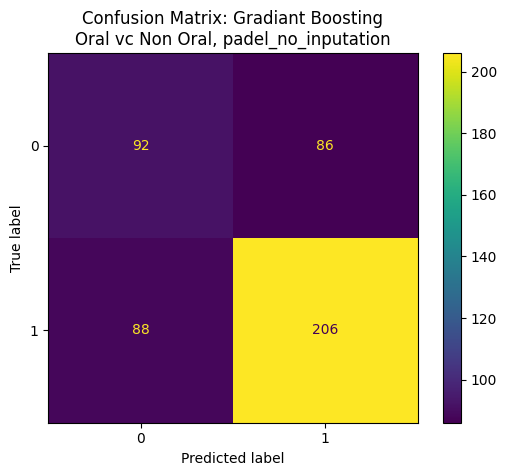

In [83]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

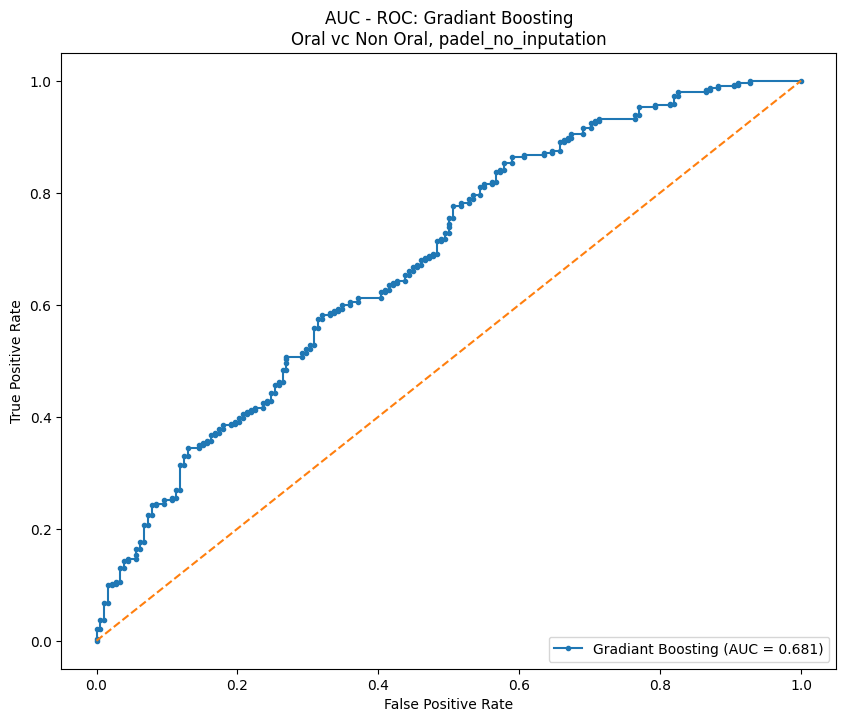

In [84]:
auc_boo = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boo_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

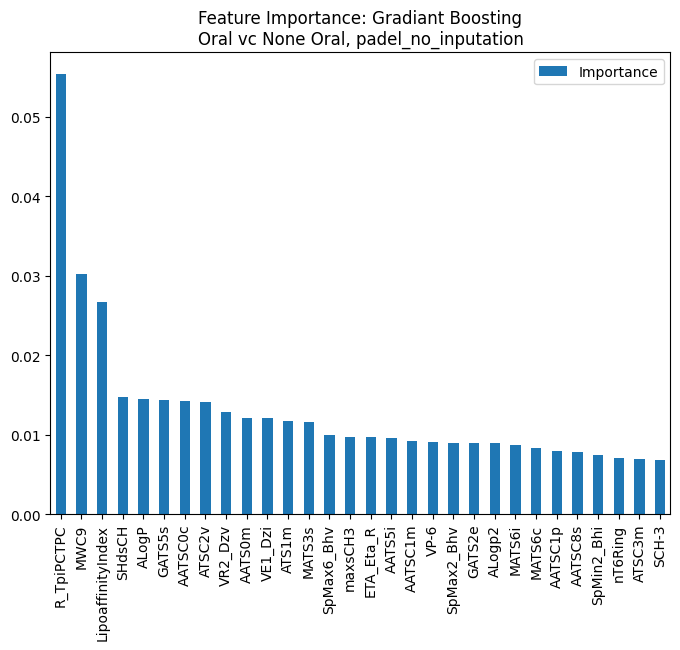

In [85]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(boosting.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [86]:
important_features_boo = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_boo

,Importance
maxaaNH,9.727619e-22
n7Ring,2.458815e-21
minwHBd,2.833307e-21
minHtCH,2.591264e-19
maxsBr,1.269368e-18
...,...
ALogP,1.448534e-02
SHdsCH,1.480679e-02
LipoaffinityIndex,2.677771e-02
MWC9,3.029326e-02


## Saving Results

In [87]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_boo["best_score"][0],
    mis_rate_boo_train,
    mis_rate_boo,
    auc_boo_train,
    auc_boo
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.596802,0.146290,0.372881,0.836953,0.626844
1,Decision Tree,0.632305,0.269965,0.351695,0.651051,0.629032
2,Random Forest,0.700517,0.002827,0.294492,0.996262,0.716369
3,Gradiant Boosting,0.658980,0.002827,0.368644,0.996262,0.680960


In [88]:
important_features_boo.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# BART

## Model Constant Variables

In [89]:
model_name_title = "BART"
model_name_path = "bart"

## Hyperparameter Fine Tuning

In [90]:
# transforming x train and test as arrays for BART procedure

x_train_bart = np.asarray(x_train)
x_test_bart = np.asarray(x_test)

In [91]:
model_params = {
    'BART': {
        'model': BART(),
        'params': {
            'num_trees': [100, 500, 1000],
            'max_stages': [100, 500, 800, 1000], # B, number of iterations
            'burnin': [5, 10, 20]
        }
    }
}

For BART, the auc present in the best_params_grid need to recieve the y_predicted in labels, but this BART algorithm does it in probabilities. Because of this, I need to use a custom scorer, that first transforms the prediction to labels.

In [92]:
score = make_scorer(bart_auc_scorer, greater_is_better=True)

gs_result_bart, gs_result_bart_full = best_params_grid(x_train_bart, y_train, model_params, scoring=score)

Starting Grid Search for BART: 03:07


Finished Grid Search for BART: 07:49
Tempo de execução:  282.3 minutos


In [93]:
gs_result_bart

,model,best_score,best_params
0,BART,0.599063,"{'burnin': 5, 'max_stages': 1000, 'num_trees':..."


# Fitting Model

In [94]:
bart_params = gs_result_bart.iloc[0,2]
bart_params

{'burnin': 5, 'max_stages': 1000, 'num_trees': 500}

In [95]:
bart = BART(**bart_params)
bart.fit(x_train_bart, y_train)

BART(burnin=5, max_stages=1000, num_trees=500)

## Get Training Error and AUC

In [96]:
mis_rate_bart_train, auc_bart_train = get_error_and_auc(
    model=bart, 
    x=x_train_bart,
    y_true=y_train,
    transform_prob_into_label=True
)

Training Misclassification Rate: 0.2749
Training AUC: 0.6669


## Make Prediction

In [97]:
# the bart algorithm predicts as probabilities
y_predict_bart_prob = bart.predict(x_test_bart)

In [98]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

y_predict_bart_label = make_label_v(y_predict_bart_prob)

## Test Error

In [99]:
mis_rate_bart, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_bart_label,
)

Misclassification rate: 0.3242


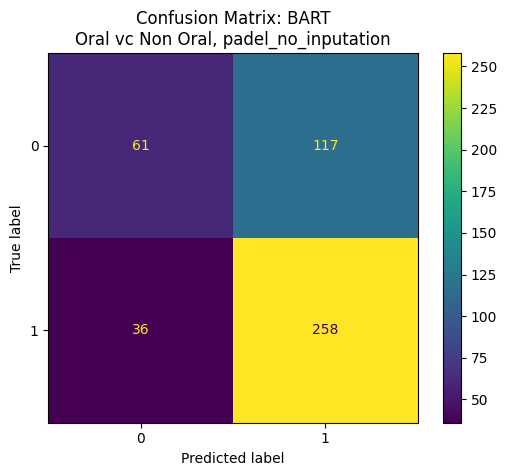

In [100]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

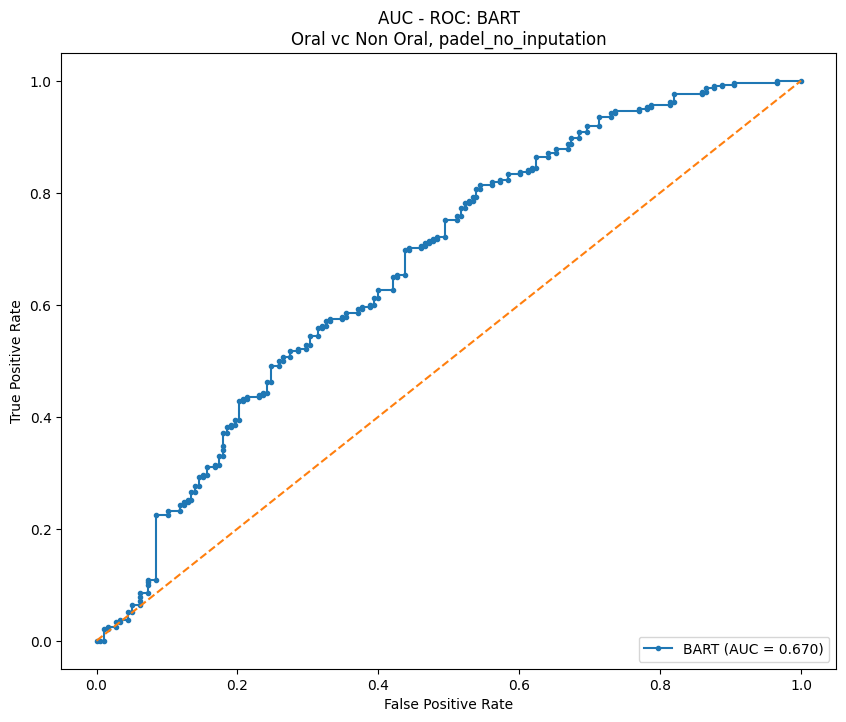

In [101]:
auc_bart = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_bart_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

We can check how many times each variable appeared in the collection
of trees. This gives a summary similar to the variable importance plot for
boosting and random forests.

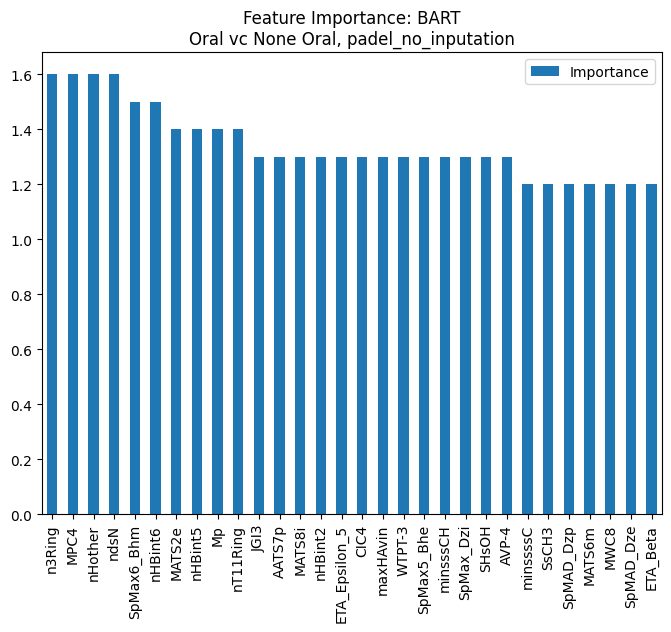

In [102]:
# Print the feature importances
fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(columns=["Importance"])
feat_importances["Importance"] = pd.Series(bart.variable_inclusion_.mean(0),index=X.columns).sort_values(ascending=False)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)


In [103]:
important_features_bart = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_bart

,Importance
ATS6s,0.1
AATS5p,0.1
ATSC7s,0.1
GATS3p,0.1
piPC3,0.1
...,...
SpMax6_Bhm,1.5
ndsN,1.6
nHother,1.6
MPC4,1.6


## Saving Results

In [104]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_bart["best_score"][0],
    mis_rate_bart_train,
    mis_rate_bart,
    auc_bart_train,
    auc_bart
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.596802,0.146290,0.372881,0.836953,0.626844
1,Decision Tree,0.632305,0.269965,0.351695,0.651051,0.629032
2,Random Forest,0.700517,0.002827,0.294492,0.996262,0.716369
3,Gradiant Boosting,0.658980,0.002827,0.368644,0.996262,0.680960
4,BART,0.599063,0.274912,0.324153,0.666860,0.669858


In [105]:
important_features_bart.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# SVM

## Model Constant Variables

In [106]:
model_name_title = "SVM"
model_name_path = "svm"

## Hyperparameter Fine Tuning

In [107]:
scale = 1 / (x_train.shape[1] * x_train.var().mean())

model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.3, 0.5, 0.8, 1.0, 2, 5, 10],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': ['auto', scale, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]
        }
    }
}

In [108]:
gs_result_svm, gs_result_svm_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for SVM: 07:49


Finished Grid Search for SVM: 09:22
Tempo de execução:  92.3 minutos


## Fitting Model

In [109]:
svm_params = gs_result_svm.iloc[0,2]
svm_params

{'C': 10, 'gamma': 9.755483052363405e-14, 'kernel': 'rbf'}

In [110]:
svm = SVC(**svm_params, probability=True).fit(x_train, y_train)

## Get Training Error and AUC

In [111]:
mis_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.3654
Training AUC: 0.5190


## Make Prediction

In [112]:
y_predict_svm_label = svm.predict(x_test)
y_predict_svm_prob = svm.predict_proba(x_test)[:, 1]

## Test Error

In [113]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_svm_label,
)

Misclassification rate: 0.3835


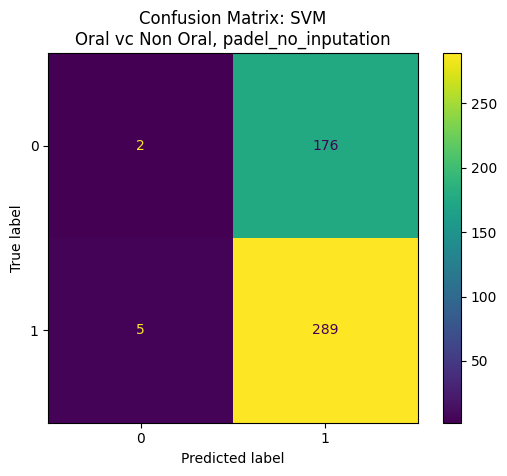

In [114]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

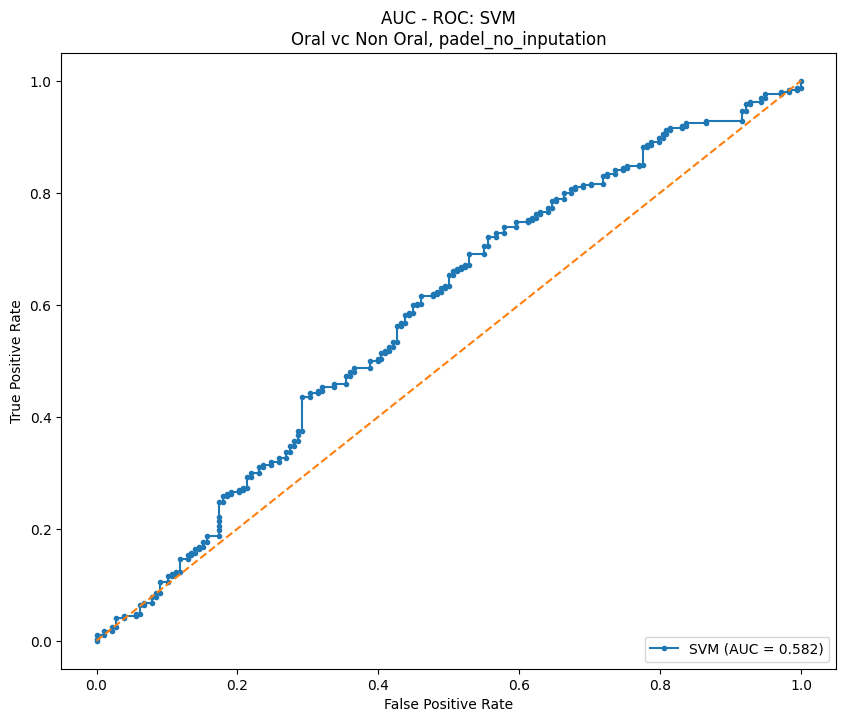

In [115]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Saving Results

In [116]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_svm["best_score"][0],
    mis_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.596802,0.146290,0.372881,0.836953,0.626844
1,Decision Tree,0.632305,0.269965,0.351695,0.651051,0.629032
2,Random Forest,0.700517,0.002827,0.294492,0.996262,0.716369
3,Gradiant Boosting,0.658980,0.002827,0.368644,0.996262,0.680960
4,BART,0.599063,0.274912,0.324153,0.666860,0.669858
5,SVM,0.595775,0.365371,0.383475,0.519021,0.582340


# Saving Final Datasets

In [117]:
# saving final_results dataset
final_results.to_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv", index=False)

In [118]:
session_info.show()